In [22]:
import torch, detectron2

from detectron2.engine import DefaultPredictor
from detectron2.config import  get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.detection_utils import read_image
import detectron2.data.transforms as T






import cv2
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [29]:
class OutOfContextDetector:
    
    def __init__(self, model_type = "OD"):
        self.cfg = get_cfg()
        
        #Load model config and pretrained model
        if model_type == "OD":
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")      
            
            
        elif model_type == "IS":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")      
            
        elif model_type == "KP":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")      
            
                
                
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.DEVICE = "cuda"
        
        self.predictor = DefaultPredictor(self.cfg)
        
        
    def onImage(self, imagePath):
        image = cv2.imread(imagePath)
        #image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        #image = cv2.rotate(image, cv2.ROTATE_180)
        
        predictions = self.predictor(image)
        print(predictions["instances"])
        print(MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]))
        
        instance_mode = ColorMode.IMAGE_BW
        scale= 10.0
        viz = Visualizer(image[:,:,::-1], metadata=MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]))
        
        output = viz.draw_instance_predictions(predictions["instances"].to("cpu"))
        
        plt.imshow(output.get_image() )
        
        plt.show()
        
        
    def get_cam(self, target_instance, layer_name, grad_cam_instance):
        """
        Calls the GradCAM instance

        Parameters
        ----------
        img : str
            Path to inference image
        target_instance : int
            The target instance index
        layer_name : str
            Convolutional layer to perform GradCAM on
        grad_cam_type : str
            GradCAM or GradCAM++ (for multiple instances of the same object, GradCAM++ can be favorable)

        Returns
        -------
        image_dict : dict
            {"image" : <image>, "cam" : <cam>, "output" : <output>, "label" : <label>}
            <image> original input image
            <cam> class activation map resized to original image shape
            <output> instances object generated by the model
            <label> label of the 
        cam_orig : numpy.ndarray
            unprocessed raw cam
        """
        model = build_model(self.cfg)
        checkpointer = DetectionCheckpointer(model)
        checkpointer.load(self.cfg.MODEL.WEIGHTS)

        input_image_dict = {"image": self.input_tensor, "height": self.image_height, "width": self.image_width}
        grad_cam = grad_cam_instance(model, layer_name)
        
        with grad_cam as cam:
            cam, cam_orig, output = cam(input_image_dict, target_instance=target_instance)
        
        output_dict = self.get_output_dict(cam, output, target_instance)
        
        return output_dict, cam_orig
    
    def get_output_dict(self, cam, output, target_instance):
        image_dict = {}
        image_dict["image"] =  self.image
        image_dict["cam"] = cam
        image_dict["output"] = output
        image_dict["label"] = MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]).thing_classes[output["instances"].pred_classes[target_instance]]
        return image_dict
        

        
        
          

Instances(num_instances=6, image_height=495, image_width=803, fields=[pred_boxes: Boxes(tensor([[471.5611, 341.7666, 586.3508, 433.0255],
        [151.2313, 315.9875, 274.9039, 455.4588],
        [273.7425,  86.4797, 677.1929, 459.1182],
        [ 68.4970, 329.1273, 287.1566, 473.7636],
        [114.1050, 171.4655, 243.5473, 284.1379],
        [171.1460, 333.0231, 305.9557, 440.3459]], device='cuda:0')), scores: tensor([0.9986, 0.9982, 0.9643, 0.9302, 0.6111, 0.5528], device='cuda:0'), pred_classes: tensor([20,  0, 20, 57, 62, 57], device='cuda:0')])
Metadata(name='coco_2017_train', json_file='datasets/coco/annotations/instances_train2017.json', image_root='datasets/coco/train2017', evaluator_type='coco', thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 3

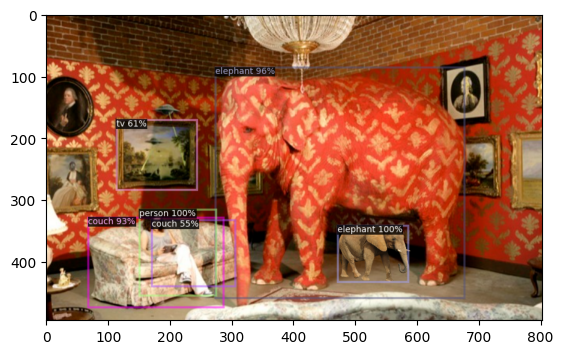

In [15]:
detector = OutOfContextDetector(model_type="OD")
detector.onImage("../datasets/out_of_context/new8.jpg")